## Convert df to a matrix

In [1]:
import uproot
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os

**Define df:**  
This dataframe only has the values of row and col for qmax and tmax differents than 0. It is saved as a pixel [row, col, qmax, tmax].

In [2]:
class ND280_dataset:
    def __init__(self, path):
        #tree_hattracks = uproot.open(path)['hatdigits']
        tree_hattracks = uproot.open(path)['hatdigits']
        
        df = tree_hattracks.arrays()
        tree = ak.to_dataframe(df)
        keys = tree.index.get_level_values('entry').unique()
        
        self.tree = tree
        self.keys = keys
        
    def __getitem__(self, i):
        key = self.keys[i]
        return self.tree.loc[key]
    
    def __len__(self):
        return len(self.keys)

In [3]:
path_1="/data/neutrinos/common/casado/T2K/HAT-Reco/treemaker_mu_minus_800.root"

In [4]:
ds = ND280_dataset(path_1)

In [5]:
df = pd.DataFrame(ds.tree)

In [6]:
df_unique_entries = df.groupby('entry').first()

In [7]:
df.groupby('entry').first()

,event,hat,plate,fem,fec,asic,channel,time,nsamples,adc,row,col,y,z,qmax,tmax,fwhm
entry,,,,,,,,,,,,,,,,,
0,0,0,0,2,1,3,9,144,52,246,4,24,849.315002,-1660.115967,292,154,24
1,0,0,0,2,1,3,10,91,68,246,4,25,849.315002,-1648.835938,650,113,22
2,0,0,0,2,1,3,11,86,49,257,4,26,849.315002,-1637.555908,1899,105,14
3,0,0,0,2,1,3,20,134,66,281,5,25,859.505005,-1648.835938,304,158,30
4,0,0,0,2,1,3,21,101,119,253,5,26,859.505005,-1637.555908,311,141,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087925,9999,0,0,7,0,0,64,73,48,227,30,4,773.255005,-1464.715942,820,91,14
2087926,9999,0,0,7,0,0,65,74,61,260,30,3,773.255005,-1475.995972,415,91,18
2087927,9999,0,0,7,0,0,72,79,52,247,31,6,783.445007,-1442.156006,357,97,23


In [8]:
print(len(df.groupby('event').first())-1)

9999


In [9]:
result_array = []
len_array = []
event_array = []

for event_value in range(9999):
    df_sel = df_unique_entries[df_unique_entries['event'] == event_value]
    
    data_list = []  
    
    for fem_value in range(8):
        df_sel_fem = df_sel[df_sel['fem'] == fem_value]
        num_inputs = len(df_sel_fem)

        if num_inputs != 0:
            mask_qmax = df_sel_fem['qmax'] != 0
            mask_tmax = df_sel_fem['tmax'] != 0

            qmax_values = df_sel_fem['qmax'][mask_qmax]
            tmax_values = df_sel_fem['tmax'][mask_tmax]
            
            # Apply row and col transformations based on fem_value
            row_offset = 0
            col_offset = 0
            if fem_value == 0:
                row_offset += 32
                col_offset += 0
            elif fem_value == 1:
                row_offset += 32
                col_offset += 36
            elif fem_value == 2:
                row_offset += 32
                col_offset += 72
            elif fem_value == 3:
                row_offset += 32
                col_offset += 108
            elif fem_value == 5:
                col_offset += 36
            elif fem_value == 6:
                col_offset += 72
            elif fem_value == 7:
                col_offset += 108

            row_values = df_sel_fem['row'][mask_qmax] + row_offset
            col_values = df_sel_fem['col'][mask_qmax] + col_offset
            
            for qmax, tmax, row, col in zip(qmax_values, tmax_values, row_values, col_values):
                data_list.append([row, col, qmax, tmax])
            
    result_array.append(data_list)
    len_array.append(len(data_list))
    event_array.append(event_value)

df_result_1 = pd.DataFrame({
    'event': event_array,
    'nhits': len_array,
    '[row, col, qmax, tmax]': result_array})

df_result_1

,event,nhits,"[row, col, qmax, tmax]"
0,0,223,"[[36, 96, 292, 154], [36, 97, 650, 113], [36, ..."
1,1,207,"[[36, 116, 293, 64], [32, 113, 671, 48], [32, ..."
2,2,217,"[[34, 88, 300, 81], [34, 89, 450, 56], [33, 88..."
3,3,207,"[[32, 98, 328, 59], [41, 106, 287, 100], [41, ..."
4,4,215,"[[36, 116, 477, 64], [37, 116, 297, 80], [32, ..."
...,...,...,...
9994,9994,223,"[[36, 70, 287, 136], [36, 71, 526, 90], [35, 6..."
9995,9995,210,"[[38, 89, 298, 125], [37, 88, 291, 123], [37, ..."
9996,9996,197,"[[40, 133, 373, 97], [40, 134, 714, 91], [41, ..."
9997,9997,223,"[[36, 98, 300, 113], [32, 95, 628, 90], [32, 9..."


In [10]:
df_result_1['npart'] = 1

In [11]:
df_result_1

,event,nhits,"[row, col, qmax, tmax]",npart
0,0,223,"[[36, 96, 292, 154], [36, 97, 650, 113], [36, ...",1
1,1,207,"[[36, 116, 293, 64], [32, 113, 671, 48], [32, ...",1
2,2,217,"[[34, 88, 300, 81], [34, 89, 450, 56], [33, 88...",1
3,3,207,"[[32, 98, 328, 59], [41, 106, 287, 100], [41, ...",1
4,4,215,"[[36, 116, 477, 64], [37, 116, 297, 80], [32, ...",1
...,...,...,...,...
9994,9994,223,"[[36, 70, 287, 136], [36, 71, 526, 90], [35, 6...",1
9995,9995,210,"[[38, 89, 298, 125], [37, 88, 291, 123], [37, ...",1
9996,9996,197,"[[40, 133, 373, 97], [40, 134, 714, 91], [41, ...",1
9997,9997,223,"[[36, 98, 300, 113], [32, 95, 628, 90], [32, 9...",1


**Convert the df to a matrix:**   
With the dataframe information, convert the pixels [row, col, qmax, tmax] to a matrix (the values of row and col that doesn't appears are supposed to be 0).

In [12]:
df_result_1.at[998, '[row, col, qmax, tmax]']

[[36, 113, 297, 126],
 [36, 113, 289, 225],
 [36, 114, 876, 91],
 [36, 114, 291, 146],
 [36, 115, 2466, 93],
 [36, 116, 936, 101],
 [37, 113, 288, 208],
 [37, 114, 401, 128],
 [37, 115, 4095, 87],
 [37, 116, 2201, 94],
 [38, 114, 304, 167],
 [38, 115, 433, 128],
 [38, 116, 382, 93],
 [39, 115, 289, 223],
 [32, 110, 294, 99],
 [32, 111, 639, 90],
 [32, 112, 352, 93],
 [33, 111, 427, 90],
 [33, 112, 720, 91],
 [33, 113, 353, 106],
 [34, 112, 403, 97],
 [34, 113, 1150, 90],
 [34, 114, 370, 102],
 [35, 112, 291, 124],
 [35, 112, 287, 159],
 [35, 113, 555, 90],
 [35, 114, 1020, 90],
 [35, 115, 455, 102],
 [35, 116, 334, 154],
 [48, 125, 315, 137],
 [47, 124, 327, 115],
 [47, 125, 843, 92],
 [46, 123, 322, 114],
 [46, 124, 925, 94],
 [46, 125, 1454, 90],
 [45, 123, 455, 92],
 [45, 124, 2086, 91],
 [45, 125, 377, 109],
 [44, 122, 421, 97],
 [44, 123, 673, 91],
 [44, 124, 348, 118],
 [43, 121, 399, 92],
 [43, 122, 522, 89],
 [43, 123, 291, 116],
 [42, 120, 339, 92],
 [42, 121, 466, 91],
 [41, 

In [13]:
matrix= np.zeros((64, 144))
for array in df_result_1.at[998, '[row, col, qmax, tmax]']:
    row, col, qmax, tmax = array
    matrix[row][col] = qmax

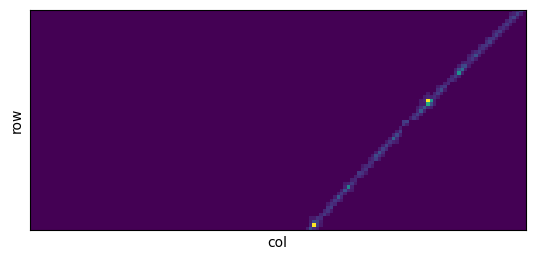

In [14]:
plt.imshow(matrix, cmap='viridis', origin='lower')  
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.xlabel('col')  
plt.ylabel('row')  
plt.show()